In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import numpy as np

In [90]:
file_path = r"C:\Users\STEVEN H\Desktop\msaa\5420 anomaly detection\1. time series for stock\all_stocks_5yr.csv"
df = pd.read_csv(file_path)

## P1. Data Preparation

In [91]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [92]:
# Basic information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [93]:
# Remove the null values
null_counts = df.isnull().sum()
null_counts

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [94]:
# Interpolation filling 
df.interpolate(method='linear', inplace=True)

C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


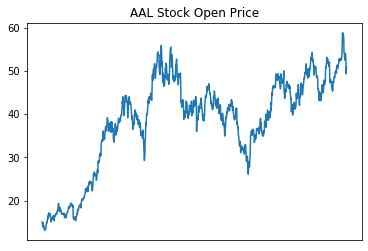

In [95]:
# See one of the stock price
stock_name = df['Name'][0]
stock_data = df[df['Name'] == stock_name]

plt.plot(stock_data['date'], stock_data['open'])
plt.title('AAL Stock Open Price')
plt.xticks([])
plt.show()

In the context of a time series dataset, interpolation can be useful because it helps maintain the continuity of the data over time. By filling in the missing values with interpolated values, we can create a more complete and continuous time series, which can be beneficial for various analysis and modeling tasks. Thus, in this situation, I chose interpolation instead of "dropna" to deal with the missing values. 

In [64]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [68]:
df = df[['date', 'volume']]

In [96]:
df = df[df['Name'] == 'AAL']

## P2. Feature Engineering

In [29]:
import pandas as pd
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['season'] = df['month'] % 12 // 3 + 1
    return df

season_names = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}
df = create_features(df)
df['season'] = df['season'].map(season_names)

I created these features but didn't use them in the later analysis.

## P3. Models

In [97]:
# 7-days' moving average
df['7_day_MA'] = df['volume'].rolling(window=7).mean()

I used 7-days average as moving average.

In [98]:
# Exponential Smoothing
df['Ex_Smoothing'] = df['volume'].ewm(alpha=0.25).mean()

alpha ranges from 0 to 1, and the closer it is to 1, the greater the weight of past observations and the more obvious the smoothing effect. I choose 0.25 as the weight

In [99]:
# Seasonal-Trend Decomposition
result = seasonal_decompose(df['volume'],model='additive', period=1)
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

In [100]:
# The Prophet module
prophet_df = df.reset_index()[['date', 'volume']]
prophet_df.columns = ['ds', 'y']  

m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

merged_df = pd.concat([df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

01:36:09 - cmdstanpy - INFO - Chain [1] start processing
01:36:09 - cmdstanpy - INFO - Chain [1] done processing


The Prophet model was used to fit and predict the time series data, and the relevant columns of the original data and predicted results were combined into a data box

## P3. Anomaly Detection

In [106]:
def find_anomalies(data, window):
    # Set upper and lower limit to 3 standard deviation
    data_std = data.rolling(window=window).std()
    data_mean = data.rolling(window=window).mean()

    anomaly_cut_off = data_std * 3
    lower_limit  = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    # Generate anomalies
    anomalies = ((data > upper_limit) | (data < lower_limit))
    return anomalies

The upper and lower limits of outliers are determined by calculating the rolling standard deviation and mean value, and the data exceeding the upper and lower limits are labeled as outliers.

#### Moving average

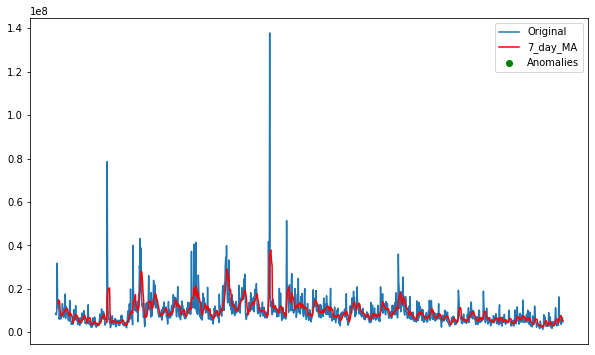

In [107]:
anomalies = find_anomalies(df['volume'], window=7)

plt.figure(figsize=(10,6))
plt.plot(df['date'], df['volume'], label='Original')
plt.plot(df['date'], df['7_day_MA'], color='red', label='7_day_MA')
plt.scatter(df[anomalies].index, df[anomalies]['volume'], color='green', label='Anomalies')
plt.legend()
plt.xticks([]) 
plt.show()


Text(0.5, 1.0, 'The distribution of diff')

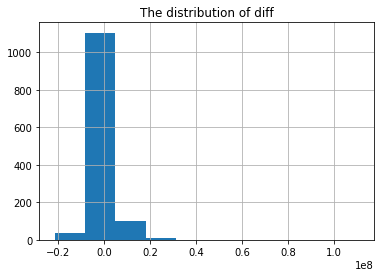

In [122]:
# Draw the histogram of 'diff' 
df['diff'].hist()
plt.title('The distribution of diff')

In [165]:
# According to the distribution of 'diff', the upper and lower thresholds are artificially set. 
df['upper'] = df['SMA'] + 15000000
df['lower'] = df['SMA'] - 15000000

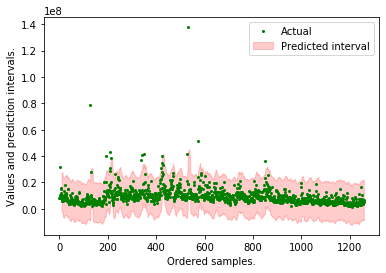

In [166]:
# Visualize
def plot_it():
    plt.plot(df['volume'], 'go', markersize=2, label='Actual')
    plt.fill_between(
        np.arange(df.shape[0]), df['lower'], df['upper'], alpha=0.2, color="r",
        label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.legend()
    plt.show()

plot_it()


This model shows the general trend of the actual data, most of data fall onto the predicted area. The distribution is also good. However, the presence of outliers at sample points 180 and 550 May indicate that some special event or activity occurred at those time points. Through further research, we can know what happened in the past.

#### Exponential Smoothing

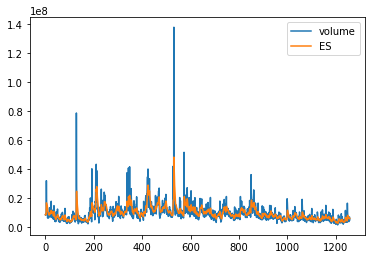

In [145]:
# Calculate Exponential Smoothing with alpha = 0.25
df['ES'] = df['volume'].ewm(alpha=0.25).mean()
df['diff'] = df['volume'] - df['ES']
df[['volume','ES']].plot()

Text(0.5, 1.0, 'The distribution of diff')

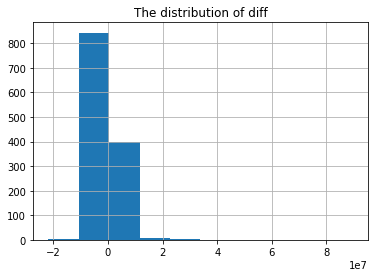

In [146]:
df['diff'].hist()
plt.title('The distribution of diff')

In [163]:
df['upper'] = df['ES'] + 12000000
df['lower'] = df['ES'] - 12000000

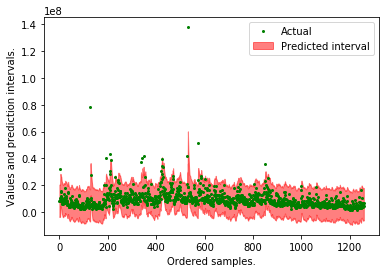

In [164]:
def plot_it():
    plt.plot(df['volume'],'go',markersize=2,label='Actual')
    plt.fill_between(
       np.arange(df.shape[0]), df['lower'], df['upper'], alpha=0.5, color="r",
       label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.legend()
    plt.show()

plot_it()

By using exponential smoothing, the model can extract long-term trends in the data and smooth the data. This allows the model to capture overall changes and trends in the data, making it easier to identify outliers that deviate from the trend.

#### Seasonal-Trend Decomposition

In [149]:
# Decompose the time series
result = seasonal_decompose(df['volume'], model='additive', period=1)

df['trend'] = result.trend

# Calculate the difference
df['diff'] = df['volume'] - df['trend']


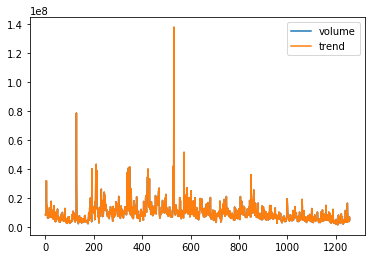

In [150]:
#trend
df[['volume','trend']].plot()

Text(0.5, 1.0, 'The distribution of diff')

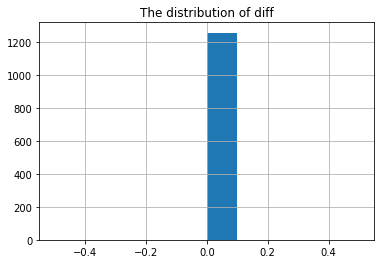

In [151]:
# Differences
df['diff'].hist()
plt.title('The distribution of diff')

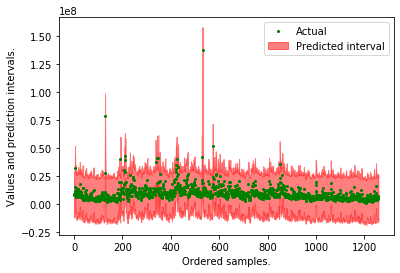

In [159]:
df['upper'] = df['trend'] + 20000000
df['lower'] = df['trend'] - 20000000

# Visualize the actual values and the thresholds
def plot_it():
    plt.plot(df['volume'],'go',markersize=2,label='Actual')
    plt.fill_between(
       np.arange(df.shape[0]), df['lower'], df['upper'], alpha=0.5, color="r",
       label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.legend()
    plt.show()

plot_it()

In the image of Seasonal-Trend Decomposition, we can see that almost all the actual values fall in the predicted interval, including some outliers, which indicates that this model has good stability and robustness.

#### The Prophet module

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\STEVEN~1\AppData\Local\Temp\tmpwhgen6zj\sw54yip2.json
DEBUG:cmdstanpy:input tempfile: C:\Users\STEVEN~1\AppData\Local\Temp\tmpwhgen6zj\gevqdpuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\STEVEN H\\Anaconda3\\envs\\week-1\\lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=56882', 'data', 'file=C:\\Users\\STEVEN~1\\AppData\\Local\\Temp\\tmpwhgen6zj\\sw54yip2.json', 'init=C:\\Users\\STEVEN~1\\AppData\\Local\\Temp\\tmpwhgen6zj\\gevqdpuz.json', 'output', 'file=C:\\Users\\STEVEN~1\\AppData\\Local\\Temp\\tmpwhgen6zj\\prophet_model3s6j5tdj\\prophet_model-20230529131412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:12 - cmdstanpy - INFO - Cha

[[<matplotlib.lines.Line2D at 0x2040039b648>],

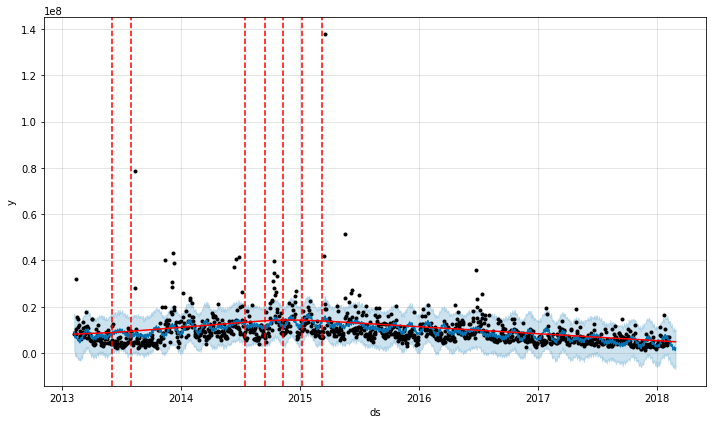

In [157]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

prophet_df = df.reset_index()[['date', 'volume']]
prophet_df.columns = ['ds', 'y']

# using daily_seasonality=True to capture daily patterns
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# For 20 days
future= model.make_future_dataframe(periods=20, freq='d')

forecast = model.predict(future)
fig = model.plot(forecast)

add_changepoints_to_plot(fig.gca(), model, forecast)

C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\STEVEN H\Anaconda3\envs\week-1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensiona

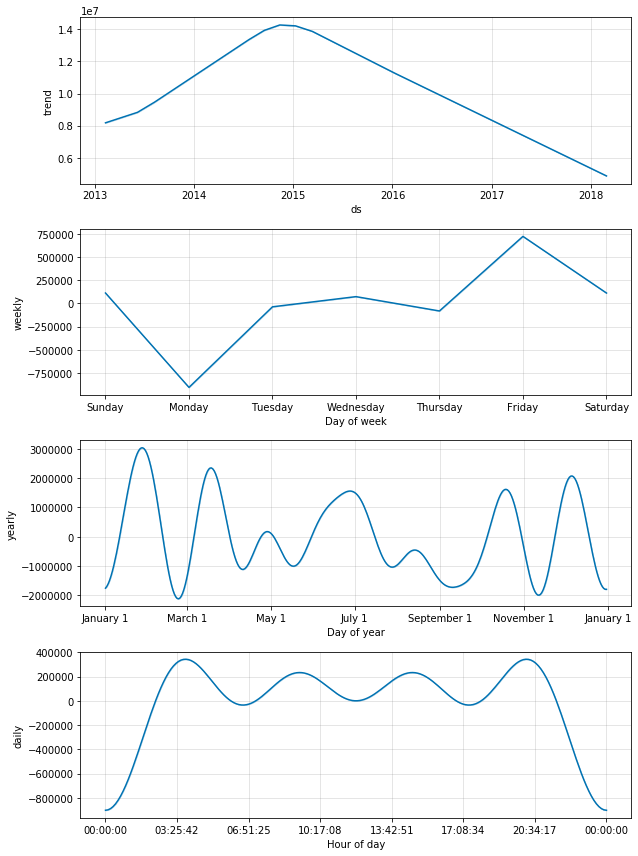

In [158]:
from prophet.plot import plot_components
fig2 = model.plot_components(forecast)

we will identify the time series anomalies by checking if the actual value is outside of the uncertainty interval. Prophet models have strong seasonal modeling capabilities to automatically capture recurring seasonal patterns in data on a daily, weekly, and monthly basis. This gives the model the flexibility to model the seasonal behavior of anomalies and to find outliers that do not fit these seasonal patterns. The Prophet model can also detect abrupt points or structural changes in time series. Therefore, this model has the ability to detect outliers